In [3]:
selected_features = [
    # IP/porta info
    'srcip', 'dstip',
    'sport', 'dsport', 'proto',
    'IPSrcType', 'IPDstType', 
    'SrcPortWellKnown', 'DstPortWellKnown', 
    'SrcPortRegistered', 'DstPortRegistered', 
    'SrcPortPrivate', 'DstPortPrivate',

    # Quantità / statistiche generali
    'dur', 'sbytes', 'dbytes', 'BytesPerPkt', 'PktPerSec', 'RatioOutIn',
    'Dload', 'Dintpkt', 'res_bdy_len',

    # Stato pacchetti
    'synack', 'ackdat',

    # TTL & timing
    'sttl', 'dttl', 'tcprtt',

    # Connessioni aggregate
    'ct_state_ttl', 'ct_srv_dst', 'ct_srv_src', 'ct_dst_src_ltm', 'dmeansz',

    # Categorical
    'state', 'service',

    # Target (non come feature ovviamente)
    'attack_cat', 'Label'
]

In [2]:
top_features = [
    # Timing e jitter
    'Sjit', 'Djit', 'Stime', 'Ltime', 'tcprtt', 'Sintpkt', 'Dintpkt',

    # TCP Flags
    'synack', 'ackdat', 'swin', 'Spkts', 'Dpkts',

    # Aggregazioni e statistiche
    'ct_state_ttl', 'ct_srv_dst', 'ct_srv_src', 'ct_dst_src_ltm', 
    'dmeansz', 'res_bdy_len', 'trans_depth', 'sbytes', 'dbytes', 
    'BytesPerPkt', 'RatioOutIn',

    # Categorical (da codificare)
    'state', 'service',
    'srcip', 'dstip', 'attack_cat',
    'srcport', 'dstport',
    # Target
    'Label'
]

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import joblib
import os

def preprocess_attack_dataset(df, protocols, scaler_type='standard', scaler_save_path=None):
    """
    df: DataFrame da preprocessare
    scaler_type: 'standard' o 'minmax'
    scaler_save_path: path per salvare lo scaler (opzionale)
    """
    df = df[selected_features]
    # df = df[top_features]
    df = pd.get_dummies(df, columns=['state', 'service'], drop_first=True)
    X = df.drop(columns=['srcip', 'dstip', 'sport', 'dsport','attack_cat', 'Label'])
    y = df['Label']
    
    # Split
    df_train, df_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    
    # Scaler
    feature_cols = list(df_train.columns)
    feature_cols.remove('proto')
    scaler = StandardScaler() if scaler_type == 'standard' else MinMaxScaler()
    df_train[feature_cols] = scaler.fit_transform(df_train[feature_cols])
    df_test[feature_cols] = scaler.transform(df_test[feature_cols])
    
    # Salvataggio scaler (facoltativo)
    if scaler_save_path:
        os.makedirs(os.path.dirname(scaler_save_path), exist_ok=True)
        joblib.dump(scaler, scaler_save_path)

    #se protocols diverso da all
    if protocols != 'all':
        #Filtra solo i protocolli desiderati
        print(f"Filtering protocols: {protocols}")
        df_train = df_train[df_train['proto'] == protocols]
        df_test = df_test[df_test['proto'] == protocols]
        df_train = df_train.reset_index(drop=True)
        df_test = df_test.reset_index(drop=True)
        # 4.2 Rimuovi la colonna proto
        df_train = df_train.drop(columns=['proto'])
        df_test = df_test.drop(columns=['proto'])
    else:
        # Target Encoding Categorical Features
        from cuml.preprocessing import TargetEncoder
        encoder = TargetEncoder(smooth=0.6)
        df_train['proto'] = encoder.fit_transform(df_train['proto'], y_train)
        df_test['proto'] = encoder.transform(df_test['proto'])
        feature_cols.append('proto')

    return df_train, df_test, y_train, y_test, scaler

In [5]:
protocols = 'all'  # Cambia qui se vuoi filtrare per protocollo specifico
if protocols != 'all':
    # Carica i dataset
    df_dos = pd.read_csv('data/attack_cat_tcp/UNSW-NB15_dos.csv')
    df_fuzzers = pd.read_csv('data/attack_cat_tcp/UNSW-NB15_fuzzers.csv')
    df_exploits = pd.read_csv('data/attack_cat_tcp/UNSW-NB15_exploits.csv')
    df_generic = pd.read_csv('data/attack_cat_tcp/UNSW-NB15_generic.csv')
    df_reconnaissance = pd.read_csv('data/attack_cat_tcp/UNSW-NB15_reconnaissance.csv')

    datasets = {
        'dos': df_dos,
        'fuzzers': df_fuzzers,
        'exploits': df_exploits,
        'generic': df_generic,
        'reconnaissance': df_reconnaissance
    }

else:
    df_dos = pd.read_csv('data/attack_cat/UNSW-NB15_dos.csv')
    df_fuzzers = pd.read_csv('data/attack_cat/UNSW-NB15_fuzzers.csv')
    df_exploits = pd.read_csv('data/attack_cat/UNSW-NB15_exploits.csv')
    df_generic = pd.read_csv('data/attack_cat/UNSW-NB15_generic.csv')
    df_reconnaissance = pd.read_csv('data/attack_cat/UNSW-NB15_reconnaissance.csv')
    df_analysis = pd.read_csv('data/attack_cat/UNSW-NB15_analysis.csv')
    df_shellcode = pd.read_csv('data/attack_cat/UNSW-NB15_shellcode.csv')
    df_backdoor = pd.read_csv('data/attack_cat/UNSW-NB15_backdoor.csv')

    datasets = {
        'dos': df_dos,
        'fuzzers': df_fuzzers,
        'exploits': df_exploits,
        'generic': df_generic,
        'reconnaissance': df_reconnaissance,
        'analysis': df_analysis,
        'shellcode': df_shellcode,
        'backdoor': df_backdoor
    }

splits = {}
protocols = 'all'  # Cambia qui se vuoi filtrare per protocollo specifico

for name, df in datasets.items():
    # Preprocessamento
    X_train, X_test, y_train, y_test, scaler = preprocess_attack_dataset(df, protocols, scaler_type='standard')
    splits[name] = {
        'X_train': X_train, 'X_test': X_test,
        'y_train': y_train, 'y_test': y_test,
        'scaler': scaler
    }

/gpuserver/caputo/miniconda3/envs/KC/lib/python3.10/site-packages/cudf/utils/_numba.py:17: UserWarning: CUDA Toolkit is newer than CUDA driver. Numba features will not work in this configuration. 
  warnings.warn(


In [6]:
import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,)

# Modelli da testare
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Bagging": BaggingClassifier(n_estimators=100, random_state=42),
    "SGD": SGDClassifier(loss="log_loss", max_iter=1000, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "Naive Bayes": GaussianNB()
}
# STEP 1: Inizializza risultati
results = []
final_results = []

# STEP 2: Ciclo per tutti i modelli e split
for split_name, data in splits.items():
    print(f"\n📊 Dataset: {split_name.upper()}")
    X_train = data['X_train']
    X_test = data['X_test']
    y_train = data['y_train']
    y_test = data['y_test']

    for model_name, model in models.items():
        print(f"\n🔧 Training {model_name}")

        # Training
        start_train = time.time()
        model.fit(X_train, y_train)
        end_train = time.time()
        train_time = end_train - start_train

        # Prediction
        start_pred = time.time()
        y_pred = model.predict(X_test)
        end_pred = time.time()
        pred_time = end_pred - start_pred

        # Metriche
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        results.append({
            "Dataset": split_name,
            "Model": model_name,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1 Score": f1,
            "Train Time (s)": train_time,
            "Test Time (s)": pred_time,
            "Type": "Cross-Validated"
        })




📊 Dataset: DOS

🔧 Training Random Forest

🔧 Training Bagging

🔧 Training SGD

🔧 Training AdaBoost


/gpuserver/caputo/miniconda3/envs/KC/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



🔧 Training Naive Bayes

📊 Dataset: FUZZERS

🔧 Training Random Forest

🔧 Training Bagging

🔧 Training SGD

🔧 Training AdaBoost


/gpuserver/caputo/miniconda3/envs/KC/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



🔧 Training Naive Bayes

📊 Dataset: EXPLOITS

🔧 Training Random Forest

🔧 Training Bagging

🔧 Training SGD

🔧 Training AdaBoost


/gpuserver/caputo/miniconda3/envs/KC/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



🔧 Training Naive Bayes

📊 Dataset: GENERIC

🔧 Training Random Forest

🔧 Training Bagging

🔧 Training SGD

🔧 Training AdaBoost


/gpuserver/caputo/miniconda3/envs/KC/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



🔧 Training Naive Bayes

📊 Dataset: RECONNAISSANCE

🔧 Training Random Forest

🔧 Training Bagging

🔧 Training SGD

🔧 Training AdaBoost


/gpuserver/caputo/miniconda3/envs/KC/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



🔧 Training Naive Bayes

📊 Dataset: ANALYSIS

🔧 Training Random Forest

🔧 Training Bagging

🔧 Training SGD

🔧 Training AdaBoost


/gpuserver/caputo/miniconda3/envs/KC/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



🔧 Training Naive Bayes

📊 Dataset: SHELLCODE

🔧 Training Random Forest

🔧 Training Bagging

🔧 Training SGD

🔧 Training AdaBoost


/gpuserver/caputo/miniconda3/envs/KC/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



🔧 Training Naive Bayes

📊 Dataset: BACKDOOR

🔧 Training Random Forest

🔧 Training Bagging

🔧 Training SGD

🔧 Training AdaBoost


/gpuserver/caputo/miniconda3/envs/KC/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



🔧 Training Naive Bayes


In [7]:
results_df = pd.DataFrame(results)

mean_metrics = results_df.groupby("Model")[["Accuracy", "Precision", "Recall", "F1 Score"]].mean().reset_index()
mean_metrics["Type"] = "Mean CV"


In [9]:
from sklearn.model_selection import train_test_split

df_full = pd.read_csv('data/UNSW-NB15_processed.csv')
# Split finale
X_train_full, X_test_full, y_train_full, y_test_full, scaler_full = preprocess_attack_dataset(df_full, protocols, scaler_type='standard')
for model_name, model in models.items():
    print(f"\n🏁 Training on FULL dataset: {model_name}")

    start_train = time.time()
    model.fit(X_train_full, y_train_full)
    end_train = time.time()
    train_time = end_train - start_train

    start_pred = time.time()
    y_pred = model.predict(X_test_full)
    end_pred = time.time()
    pred_time = end_pred - start_pred

    acc = accuracy_score(y_test_full, y_pred)
    prec = precision_score(y_test_full, y_pred, zero_division=0)
    rec = recall_score(y_test_full, y_pred, zero_division=0)
    f1 = f1_score(y_test_full, y_pred, zero_division=0)

    final_results.append({
        "Model": model_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "Train Time (s)": train_time,
        "Test Time (s)": pred_time,
        "Type": "Full Dataset"
    })



🏁 Training on FULL dataset: Random Forest

🏁 Training on FULL dataset: Bagging

🏁 Training on FULL dataset: SGD

🏁 Training on FULL dataset: AdaBoost


/gpuserver/caputo/miniconda3/envs/KC/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



🏁 Training on FULL dataset: Naive Bayes


In [10]:
final_df = pd.DataFrame(final_results)
combined_df = pd.concat([results_df, final_df], ignore_index=True)
combined_df.to_csv("model_comparison_full_vs_cv.csv", index=False)
print("\n📁 File salvato come: model_comparison_full_vs_cv.csv")



📁 File salvato come: model_comparison_full_vs_cv.csv


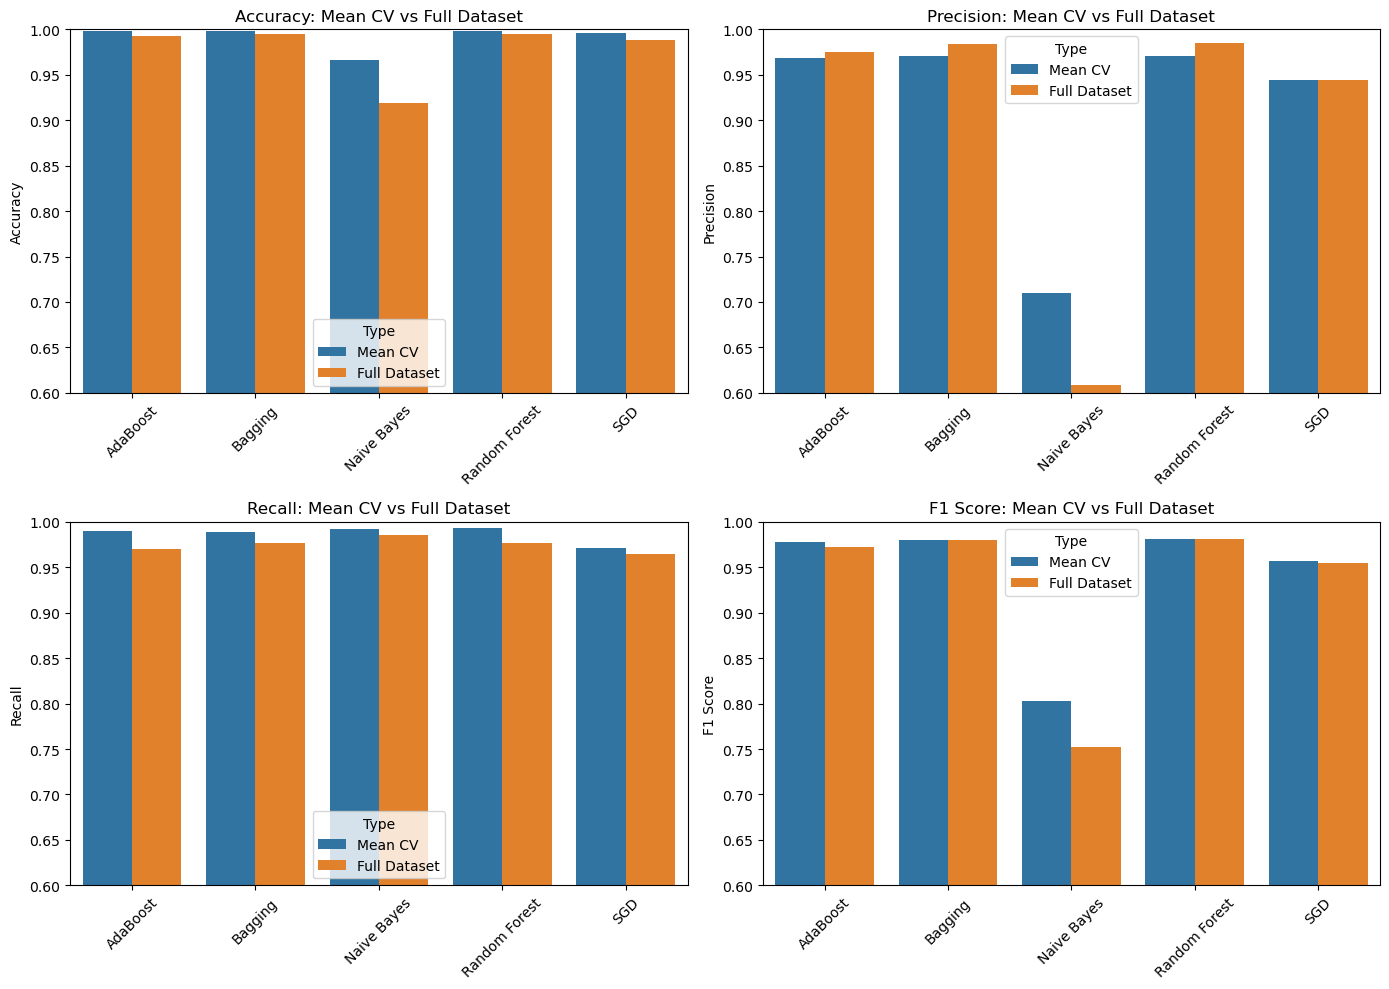

In [14]:
import seaborn as sns

metrics_to_plot = ["Accuracy", "Precision", "Recall", "F1 Score"]
plot_df = pd.concat([mean_metrics, final_df], ignore_index=True)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, metric in enumerate(metrics_to_plot):
    sns.barplot(data=plot_df, x="Model", y=metric, hue="Type", ax=axs[i])
    axs[i].set_title(f"{metric}: Mean CV vs Full Dataset")
    axs[i].set_ylim(0.60, 1.0)  # 👈 ZOOM QUI
    axs[i].set_xlabel("")
    axs[i].set_ylabel(metric)
    axs[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


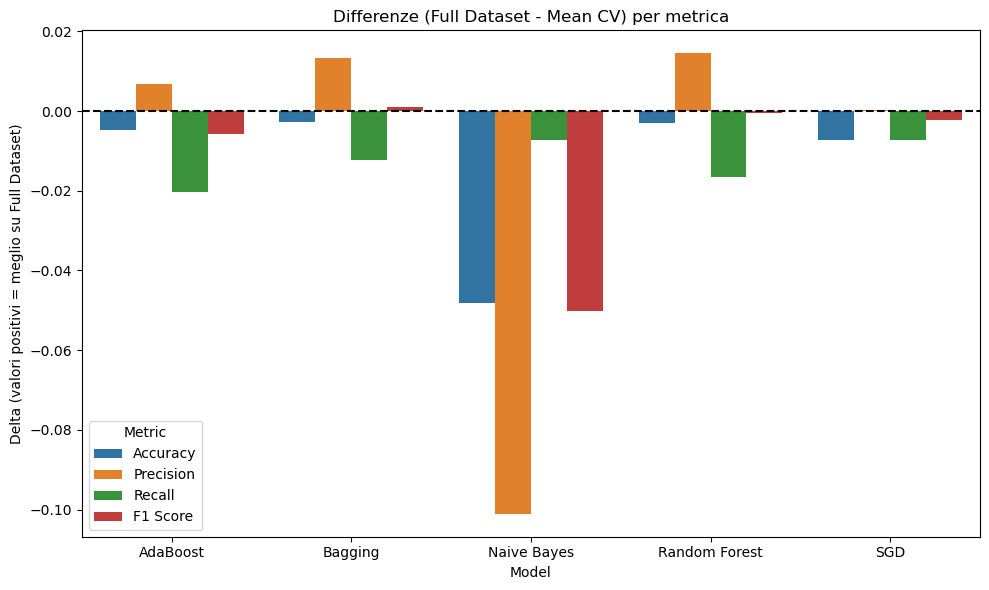

In [15]:
# Calcola differenze tra Full Dataset e Mean CV per ogni modello
delta_df = final_df.set_index("Model")[["Accuracy", "Precision", "Recall", "F1 Score"]] - \
           mean_metrics.set_index("Model")[["Accuracy", "Precision", "Recall", "F1 Score"]]
delta_df = delta_df.reset_index().melt(id_vars="Model", var_name="Metric", value_name="Delta")

plt.figure(figsize=(10, 6))
sns.barplot(data=delta_df, x="Model", y="Delta", hue="Metric")
plt.axhline(0, linestyle="--", color="black")
plt.title("Differenze (Full Dataset - Mean CV) per metrica")
plt.ylabel("Delta (valori positivi = meglio su Full Dataset)")
plt.tight_layout()
plt.show()

## TUTTI I PROTOCOLLI


🌲 Training Random Forest for: DOS
✅ Accuracy:  0.9989
✅ Precision: 0.9870
✅ Recall:    0.9908
✅ F1 Score:  0.9889


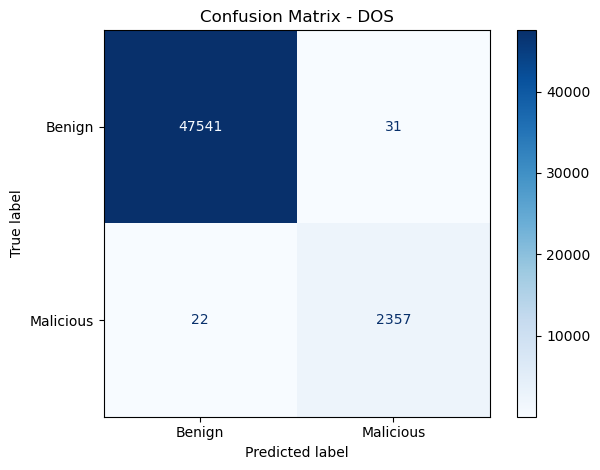

Top 10 feature:
1. Djit: 0.1807
2. sport: 0.1759
3. dur: 0.1146
4. trans_depth: 0.0848
5. Stime: 0.0448
6. Spkts: 0.0419
7. swin: 0.0351
8. Dload: 0.0292
9. Dintpkt: 0.0280
10. ct_srv_src: 0.0273

🌲 Training Random Forest for: FUZZERS
✅ Accuracy:  0.9900
✅ Precision: 0.8425
✅ Recall:    0.9729
✅ F1 Score:  0.9030


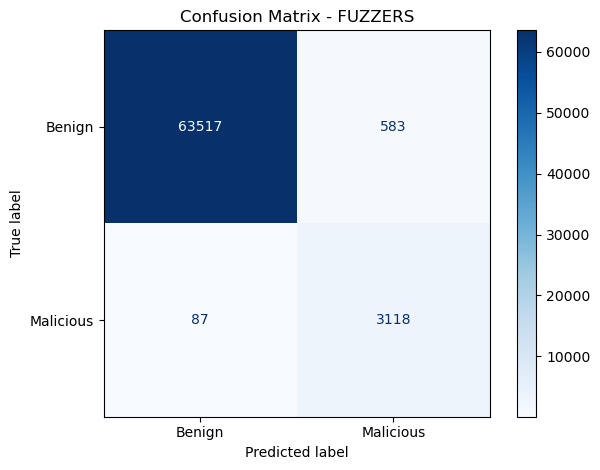

Top 10 feature:
1. Djit: 0.2064
2. trans_depth: 0.1595
3. Sjit: 0.0736
4. dmeansz: 0.0728
5. smeansz: 0.0651
6. res_bdy_len: 0.0606
7. Spkts: 0.0567
8. dwin: 0.0379
9. Sload: 0.0369
10. sport: 0.0254

🌲 Training Random Forest for: EXPLOITS
✅ Accuracy:  0.9987
✅ Precision: 0.9837
✅ Recall:    0.9886
✅ F1 Score:  0.9861


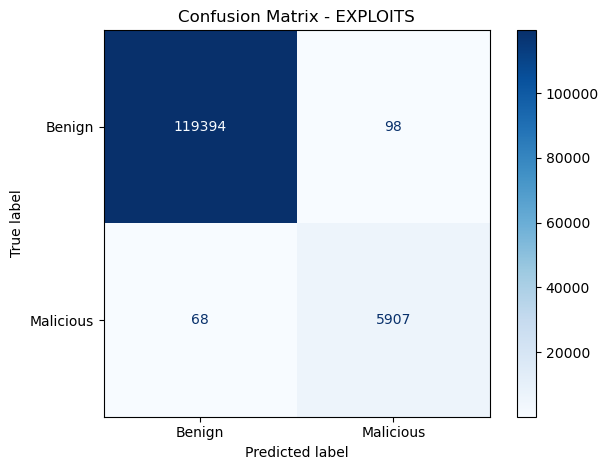

Top 10 feature:
1. Djit: 0.1561
2. trans_depth: 0.1307
3. res_bdy_len: 0.1072
4. sport: 0.1023
5. dmeansz: 0.0569
6. dur: 0.0550
7. smeansz: 0.0471
8. Sjit: 0.0398
9. Stime: 0.0382
10. Spkts: 0.0378

🌲 Training Random Forest for: GENERIC
✅ Accuracy:  0.9998
✅ Precision: 0.9996
✅ Recall:    0.9985
✅ F1 Score:  0.9990


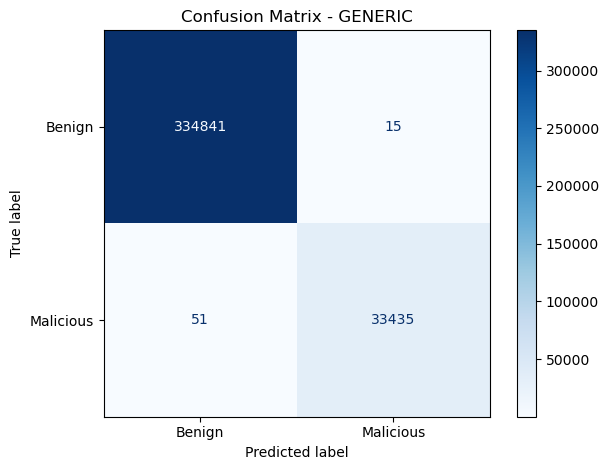

Top 10 feature:
1. Djit: 0.2173
2. Sload: 0.1889
3. Spkts: 0.1830
4. trans_depth: 0.1123
5. Dload: 0.0390
6. Dpkts: 0.0377
7. ct_srv_src: 0.0349
8. res_bdy_len: 0.0310
9. dloss: 0.0265
10. swin: 0.0230

🌲 Training Random Forest for: RECONNAISSANCE
✅ Accuracy:  0.9996
✅ Precision: 0.9961
✅ Recall:    0.9953
✅ F1 Score:  0.9957


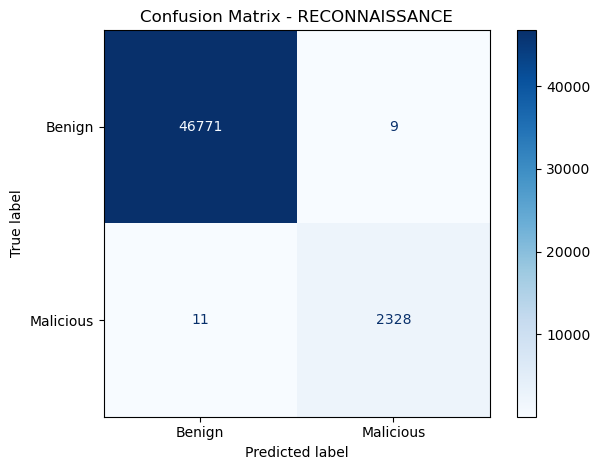

Top 10 feature:
1. Djit: 0.1966
2. trans_depth: 0.1595
3. Spkts: 0.1217
4. Sload: 0.0622
5. Dintpkt: 0.0451
6. Stime: 0.0424
7. dwin: 0.0372
8. res_bdy_len: 0.0365
9. Sintpkt: 0.0326
10. dmeansz: 0.0325


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np


for name, data in splits.items():
    print(f"\n🌲 Training Random Forest for: {name.upper()}")
    
    # Estrai dati
    X_train = data['X_train']
    X_test = data['X_test']
    y_train = data['y_train']
    y_test = data['y_test']
    
    # Addestra Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    # Predizione sul test
    y_pred = rf.predict(X_test)

    # Calcolo metriche
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"✅ Accuracy:  {acc:.4f}")
    print(f"✅ Precision: {prec:.4f}")
    print(f"✅ Recall:    {rec:.4f}")
    print(f"✅ F1 Score:  {f1:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malicious"])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {name.upper()}")
    plt.tight_layout()
    plt.show()

    # # Feature importance
    # importances = rf.feature_importances_
    # feature_names = df.drop(columns=['srcip', 'dstip', 'attack_cat', 'Label'])
    # feature_names = pd.get_dummies(feature_names, columns=['state', 'service'], drop_first=True).columns
    # indices = np.argsort(importances)[::-1]
    
    # print("Top 10 feature:")
    # for i in range(10):
    #     print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")


## SOLO TCP


🌲 Training Random Forest for: DOS
✅ Accuracy:  0.9976
✅ Precision: 0.9685
✅ Recall:    0.9805
✅ F1 Score:  0.9745


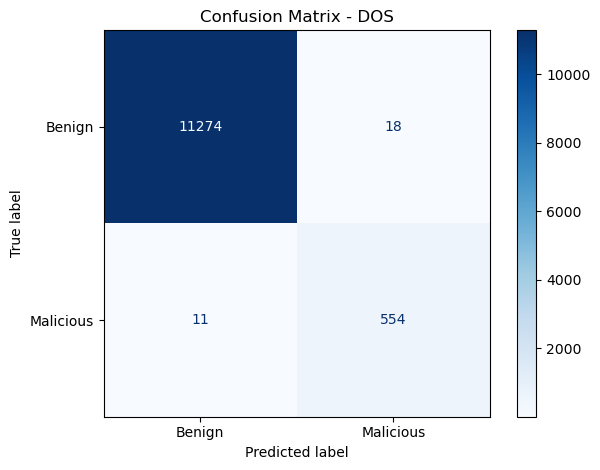


🌲 Training Random Forest for: FUZZERS
✅ Accuracy:  0.9872
✅ Precision: 0.8133
✅ Recall:    0.9486
✅ F1 Score:  0.8758


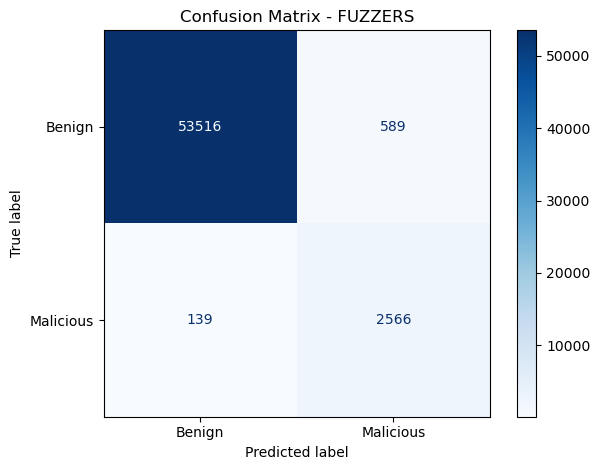


🌲 Training Random Forest for: EXPLOITS
✅ Accuracy:  0.9980
✅ Precision: 0.9751
✅ Recall:    0.9829
✅ F1 Score:  0.9790


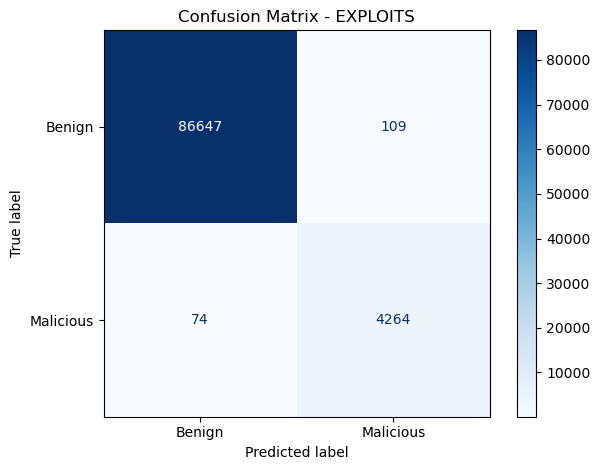


🌲 Training Random Forest for: GENERIC
✅ Accuracy:  0.9980
✅ Precision: 0.9787
✅ Recall:    0.9787
✅ F1 Score:  0.9787


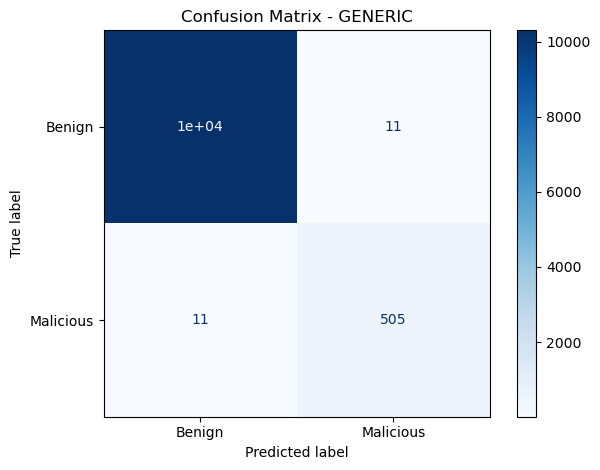


🌲 Training Random Forest for: RECONNAISSANCE
✅ Accuracy:  0.9994
✅ Precision: 0.9948
✅ Recall:    0.9926
✅ F1 Score:  0.9937


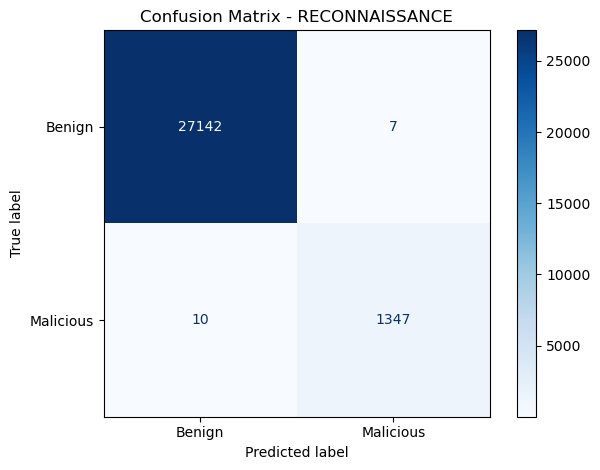

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np


for name, data in splits.items():
    print(f"\n🌲 Training Random Forest for: {name.upper()}")
    
    # Estrai dati
    X_train = data['X_train']
    X_test = data['X_test']
    y_train = data['y_train']
    y_test = data['y_test']
    
    # Addestra Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    # Predizione sul test
    y_pred = rf.predict(X_test)

    # Calcolo metriche
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"✅ Accuracy:  {acc:.4f}")
    print(f"✅ Precision: {prec:.4f}")
    print(f"✅ Recall:    {rec:.4f}")
    print(f"✅ F1 Score:  {f1:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malicious"])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {name.upper()}")
    plt.tight_layout()
    plt.show()

    # # Feature importance
    # importances = rf.feature_importances_
    # feature_names = df.drop(columns=['srcip', 'dstip', 'attack_cat', 'Label'])
    # feature_names = pd.get_dummies(feature_names, columns=['state', 'service'], drop_first=True).columns
    # indices = np.argsort(importances)[::-1]
    
    # print("Top 10 feature:")
    # for i in range(10):
    #     print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")
